In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 7.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=857ff9622796a611ebdbc8b4bafc8b0908e0e966fabffdbec9e85cc5c785ff33
  Stored in directory: /home/codespace/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark

[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

spark=SparkSession.builder.appName('FordGoBike').getOrCreate()
spark




23/05/09 08:58:11 WARN Utils: Your hostname, codespaces-3e9f4e resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
23/05/09 08:58:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/09 08:58:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
path="/workspaces/develhope-Data5-Team3/Data/week_3"
df=spark.read.csv(path,header=True, inferSchema=True)

In [4]:
df.columns

['start_time',
 'start_am_pm',
 'end_time',
 'end_am_pm',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'bike_id',
 'user_type',
 'member_birth_year',
 'member_gender',
 'pyment',
 'haversine_distance',
 'Diff_in_seconds',
 'Diff_in_minutes',
 'Trip_cost',
 'age',
 'age_group']

##TASK_1 - calculate the total cost for all customers and all subscribers

In [5]:
df.groupBy('user_type').agg({'Trip_cost': 'sum'}).show()

+----------+------------------+
| user_type|    sum(Trip_cost)|
+----------+------------------+
|Subscriber|1700972.6358333367|
|  Customer|  438035.984166667|
+----------+------------------+



##TASK_2 - Analyze how often bikes are being rented ( morning - afternoon - evening) and and find the density for each hour of the day

In [6]:
#https://www.britannica.com/dictionary/eb/qa/parts-of-the-day-early-morning-late-morning-etc

df=df.withColumn('time_of_the_day', F.when(((F.hour('start_time')>=5) & (F.hour('start_time')<12)),'Morning')\
                      .otherwise(F.when((F.hour('start_time')>=12)&(F.hour('start_time')<18),'Afternoon')\
                      .otherwise(F.when((F.hour('start_time')>=18)&(F.hour('start_time')<21),'Evening')\
                                 .otherwise('Night'))))


In [7]:
df_time_of_day=df.groupBy('time_of_the_day').agg(F.count('start_time').alias('total_rents'))

In [8]:
df_time_of_day.show()

+---------------+-----------+
|time_of_the_day|total_rents|
+---------------+-----------+
|        Evening|      77975|
|        Morning|     170438|
|      Afternoon|     171018|
|          Night|      22394|
+---------------+-----------+



In [9]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [10]:
pd=df_time_of_day.toPandas()

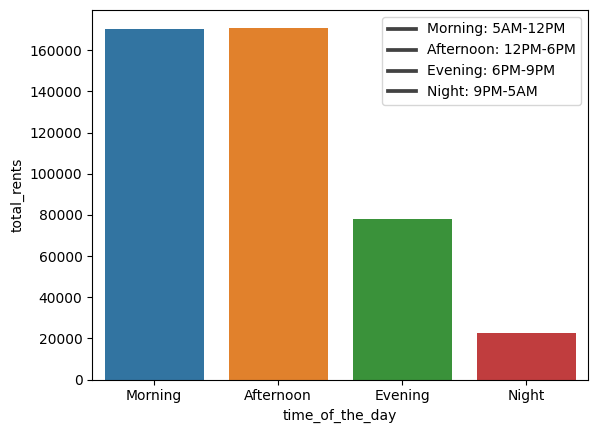

In [11]:
sn.barplot(x= pd["time_of_the_day"], y= pd['total_rents'], data=pd, order=['Morning','Afternoon','Evening','Night'])
plt.legend(['Morning: 5AM-12PM', 'Afternoon: 12PM-6PM','Evening: 6PM-9PM', 'Night: 9PM-5AM'])

In [12]:
df_hour=df.groupBy(F.hour('start_time').alias('hour')).agg(F.count('start_time').alias('total_count')).sort(F.hour('start_time'))

In [13]:
df_hour.show()

+----+-----------+
|hour|total_count|
+----+-----------+
|   1|       1254|
|   2|        559|
|   3|        234|
|   4|        564|
|   5|       1927|
|   6|       8365|
|   7|      25416|
|   8|      54276|
|   9|      41677|
|  10|      20459|
|  11|      18318|
|  12|      22880|
|  13|      20242|
|  14|      18072|
|  15|      21627|
|  16|      34551|
|  17|      53646|
|  18|      40880|
|  19|      22940|
|  20|      14155|
+----+-----------+
only showing top 20 rows



In [14]:
pd_2=df_hour.toPandas()

<Axes: xlabel='hour', ylabel='total_count'>

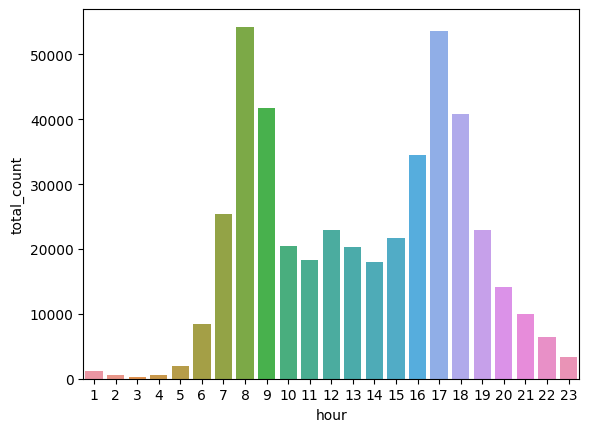

In [15]:
sn.barplot(x= pd_2["hour"], y= pd_2['total_count'], data=pd_2)

##TASK_3 - Find if there is a relation between the time and start stations